# Entrenamiento para Modelos RL

## Librerias

In [9]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from gym_envs import make_galaxian_env
from utils import set_global_seed, get_seed
from models import DQN, DuelingDQN
from replay_buffer import ReplayBuffer

import matplotlib.pyplot as plt

## Configuración de CUDA

In [10]:
seed = get_seed()
if seed is not None:
    print(f"Usando SEED global = {seed}")
    set_global_seed(seed)
else:
    # Crear una semilla aleatoria y usarla
    seed = np.random.randint(0, 10000)
    set_global_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Usando SEED global = 42
Using GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Creación de Entorno con procesamiento

In [11]:
# Crear entorno con preprocesamiento estilo DeepMind
env = make_galaxian_env(
    render_mode=None,           # para entrenamiento, más rápido
    deepmind_wrappers=True,     # aplica AtariPreprocessing + FrameStackObservation
    frame_stack=4,              # número de frames a apilar
)

# Probar entorno
obs, info = env.reset()
print("Tipo de obs:", type(obs))
obs_arr = np.array(obs, copy=False)
print("Shape de obs (np.array):", obs_arr.shape)
print("Dtype de obs:", obs_arr.dtype)

num_actions = env.action_space.n
print("Número de acciones:", num_actions)

Tipo de obs: <class 'numpy.ndarray'>
Shape de obs (np.array): (4, 84, 84)
Dtype de obs: uint8
Número de acciones: 6


## Helper para convertir obs → estado (C, H, W)

In [12]:
def obs_to_state(obs) -> np.ndarray:
    """
    Convierte la observación del entorno (que puede venir como LazyFrames
    u otro tipo) a un np.ndarray con shape (C, H, W).
    Args:
        obs: observación del entorno
    Returns:
        np.ndarray con shape (C, H, W)
    """
    arr = np.array(obs, copy=False)

    if arr.ndim == 3:
        # Casos típicos:
        # - (H, W, C)
        # - (C, H, W)
        H, W = 84, 84  # por diseño de AtariPreprocessing

        if arr.shape[0] == H and arr.shape[1] == W:
            # (H, W, C) -> (C, H, W)
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.shape[1] == H and arr.shape[2] == W:
            # ya está en (C, H, W), no tocamos
            pass
        else:
            raise ValueError(f"Shape de obs inesperado: {arr.shape}")
    elif arr.ndim == 2:
        # 1 frame (H, W) -> (1, H, W)
        arr = arr[None, ...]
    else:
        raise ValueError(f"Obs con ndim no soportado: {arr.ndim}")

    return arr

## Crear modelo, target, replay buffer e hyperparámetros

In [13]:
# A partir del state shape, definimos in_channels
state = obs_to_state(obs)
in_channels = state.shape[0]

# Modelo online y target (DQN clásico)
online_net = DQN(in_channels=in_channels, num_actions=num_actions).to(device)
target_net = DQN(in_channels=in_channels, num_actions=num_actions).to(device)
target_net.load_state_dict(online_net.state_dict())
target_net.eval()

optimizer = optim.Adam(online_net.parameters(), lr=1e-4)

# Replay buffer (pequeño para pruebas)
buffer_capacity = 10_000
obs_shape = state.shape  # (C, H, W)
replay_buffer = ReplayBuffer(
    capacity=buffer_capacity,
    obs_shape=obs_shape,
    device=device,
    dtype=np.uint8,          # guardamos los frames crudos
)

# Hyperparámetros mínimos para prueba
gamma = 0.99
batch_size = 32
start_learning_after = 1_000   # pasos de calentamiento
target_update_freq = 1_000     # cada N steps copiamos pesos a target
max_steps = 5_000              # total de steps para este test pequeño
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay_steps = 4_000

## Función epsilon-greedy y helper de actualización DQN

In [14]:
def epsilon_by_step(step: int) -> float:
    if step >= epsilon_decay_steps:
        return epsilon_end
    else:
        # decaimiento lineal
        return epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps)

def select_action(state: np.ndarray, step: int) -> int:
    """
    state: np.ndarray (C, H, W)
    """
    epsilon = epsilon_by_step(step)

    if np.random.rand() < epsilon:
        # acción aleatoria
        return np.random.randint(0, num_actions)
    else:
        # acción greedily de la red
        state_t = torch.as_tensor(state, device=device).unsqueeze(0)  # (1, C, H, W)
        with torch.no_grad():
            q_values = online_net(state_t)         # (1, num_actions)
            action = int(q_values.argmax(dim=1).item())
        return action

def dqn_update():
    """
    Un solo paso de actualización DQN a partir de un batch del replay buffer.
    """
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Q(s,a) actual
    q_values = online_net(states)                       # (B, num_actions)
    q_sa = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # (B,)

    # max_a' Q_target(s',a')
    with torch.no_grad():
        next_q_values = target_net(next_states)         # (B, num_actions)
        max_next_q = next_q_values.max(dim=1).values    # (B,)
        target = rewards + gamma * (1.0 - dones) * max_next_q

    loss = nn.MSELoss()(q_sa, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


## Loop de entrenamiento de prueba

In [15]:
num_episodes = 10           # pequeño, es prueba
global_step = 0
all_rewards = []

for episode in range(1, num_episodes + 1):
    obs, info = env.reset(seed=seed)
    state = obs_to_state(obs)
    done = False
    episode_reward = 0.0

    if global_step >= max_steps or done:
        print("[INFO] Alcanzado el máximo de pasos globales.")
        break

    while not done and global_step < max_steps:
        action = select_action(state, global_step)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state = obs_to_state(next_obs)

        replay_buffer.add(
            state=state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done,
        )

        state = next_state
        episode_reward += reward
        global_step += 1

        # Empezar a entrenar después de cierto número de pasos
        loss = None
        if global_step > start_learning_after:
            loss = dqn_update()

        # Actualizar red target cada cierto número de pasos
        if global_step % target_update_freq == 0:
            target_net.load_state_dict(online_net.state_dict())
        
        # Por si llegamos al límite de pasos
        if global_step >= max_steps:
            done = True
            break

    all_rewards.append(episode_reward)
    print(
        f"Episodio {episode:3d} | Paso global {global_step:5d} | "
        f"Reward: {episode_reward:5.1f} | "
        f"Epsilon: {epsilon_by_step(global_step):.3f}"
    )

print("Recompensas por episodio:", all_rewards)

Episodio   1 | Paso global   532 | Reward: 600.0 | Epsilon: 0.880
Episodio   2 | Paso global   858 | Reward: 520.0 | Epsilon: 0.807
Episodio   3 | Paso global  1512 | Reward: 1070.0 | Epsilon: 0.660
Episodio   4 | Paso global  2034 | Reward: 500.0 | Epsilon: 0.542
Episodio   5 | Paso global  2562 | Reward: 780.0 | Epsilon: 0.424
Episodio   6 | Paso global  2826 | Reward: 270.0 | Epsilon: 0.364
Episodio   7 | Paso global  3394 | Reward: 800.0 | Epsilon: 0.236
Episodio   8 | Paso global  3846 | Reward: 490.0 | Epsilon: 0.135
Episodio   9 | Paso global  4520 | Reward: 610.0 | Epsilon: 0.100
Episodio  10 | Paso global  5000 | Reward: 670.0 | Epsilon: 0.100
Recompensas por episodio: [600.0, 520.0, 1070.0, 500.0, 780.0, 270.0, 800.0, 490.0, 610.0, 670.0]


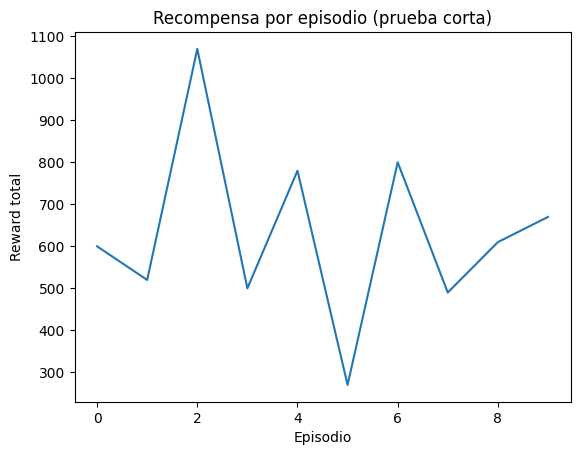

In [16]:
plt.plot(all_rewards)
plt.xlabel("Episodio")
plt.ylabel("Reward total")
plt.title("Recompensa por episodio (prueba corta)")
plt.show()